In [1]:
import sys
sys.path.append('/home/etl/Test_Stand/tbanalyisis/') #stupid python
import os
import numpy as np
from utils import plotting as pu
from utils import analysis as au
import awkward as ak
import importlib

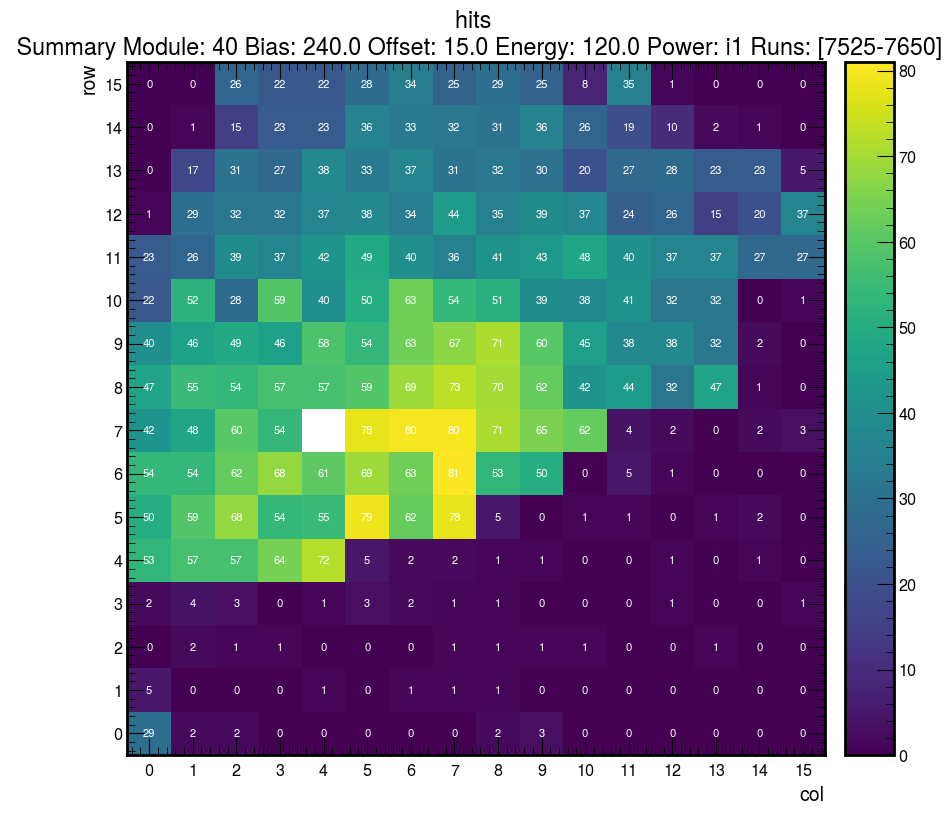

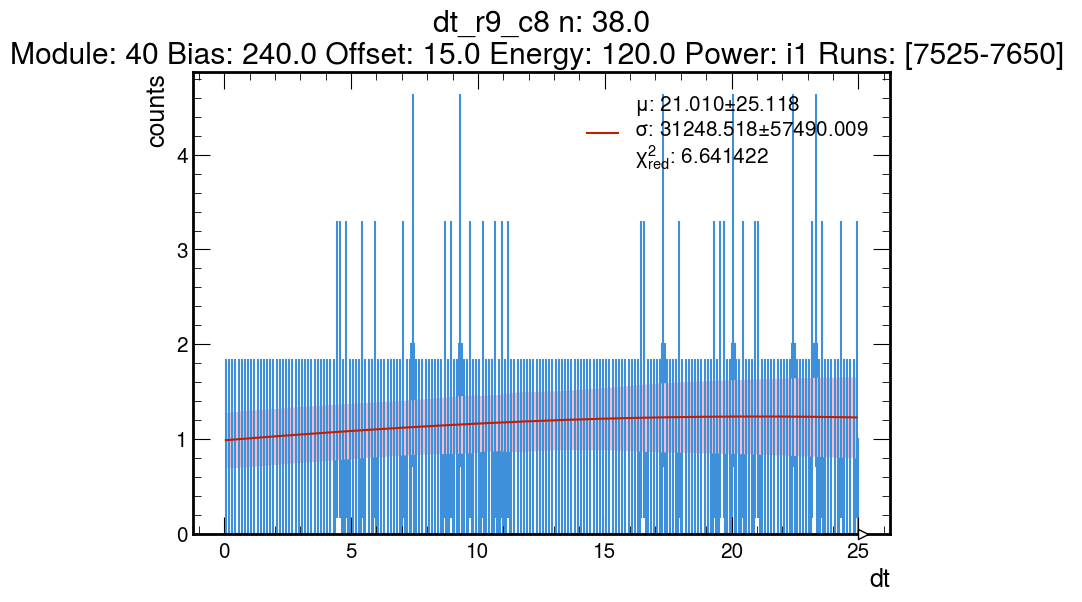

In [12]:

before_clock_update = "/home/etl/Test_Stand/tbanalyisis/output_analysis_data/merge_etroc_first_test/start_7524_stop_7650_setup_36-40_offset_15.0_energy_120.0_power_i1_module_40_bias_240_file_from_SPS_LP2_20_cubicLM_unbinned"
after_clock_update = "/home/etl/Test_Stand/tbanalyisis/output_analysis_data/merge_etroc_first_test2/start_7525_stop_7650_setup_36-40_offset_15.0_energy_120.0_power_i1_module_40_bias_240_file_from_SPS_LP2_20_cubicLM_unbinned"

after_36 = "/home/etl/Test_Stand/tbanalyisis/output_analysis_data/merge_etroc_first_test2/start_7525_stop_7650_setup_36-40_offset_15.0_energy_120.0_power_i1_module_36_bias_240_file_from_SPS_LP2_20_cubicLM_unbinned"
new_sps = pu.TBplot(
    # before_clock_update,
    # after_clock_update,
    after_36,
    load_full_collection=True
)

new_sps.hist_bins['dt'] = (200, 0, 25)
# new_sps.histo1D('cal_code')
# new_sps.histo1D('cal_code')
# new_sps.heatmap('tot_code', 'toa_code')

new_sps.sensor_map('hits')
new_sps.histo1D('dt', pix=(9,8))

In [13]:
#import one of the root files
import uproot

data_path = "/ceph/cms/store/user/iareed/ETL/DESY_Mar24"

run_data = uproot.open( os.path.join(data_path, 'run_5051.root') )['pulse']


In [7]:
chnl = run_data['channel'].array()

chnl


<Array [[[-0.00285, ..., -0.00656], ...], ...] type='5000 * 4 * 502 * float32'>

In [7]:
data_path = "/ceph/cms/store/user/iareed/ETL/SPS_May24"


run_data = uproot.open( os.path.join(data_path, 'run_7000_rb0.root') )['pulse']



-----------
5000 * 4 * 502 * float32
None
5000 * 502 * float32
None
5000 * 502 * float32
None
-----------
[3.14, 3.24, 3.34, 3.44, 3.54, 3.64, 3.74, 3.84]
5000 * var * float64
add clock clock: None
5000 * var * float64
Add clock times: None


array([-1.97676983,  6.43284515,  1.67911944, ..., -6.43839228,
       -1.6128278 ,  5.21947239])

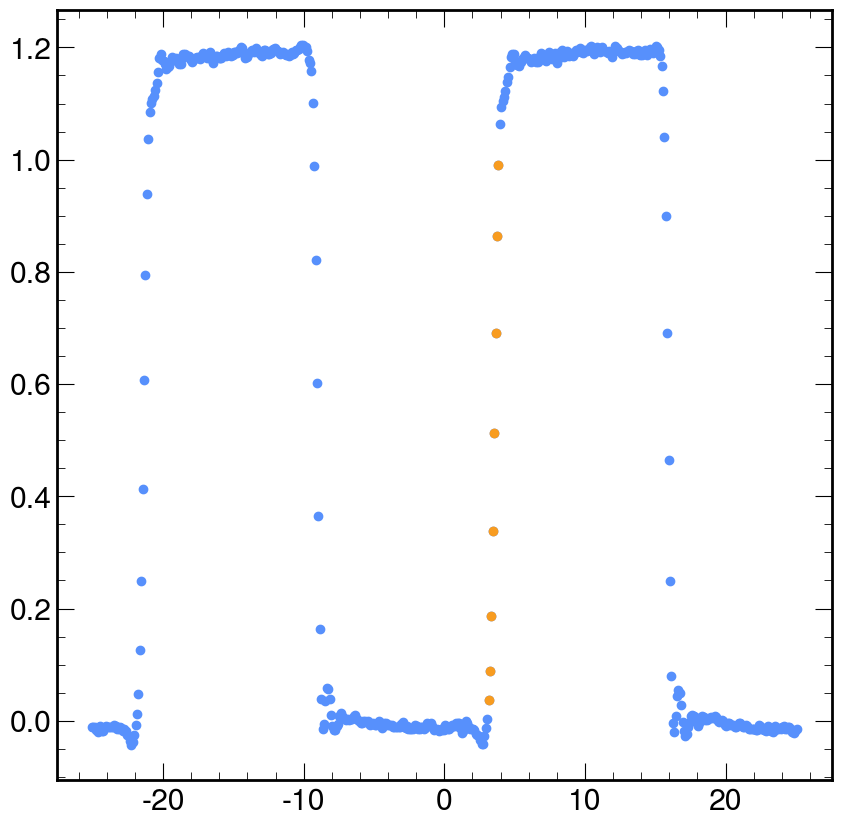

In [16]:
# chnl = run_data['channel'].array()
# chnl[:,2]
def add_clock(tree):
    import numpy as np
    import matplotlib.pyplot as plt

    channel = tree['channel'].array()
    time = tree['time'].array()
    nSamples = len(time)
    print("-----------")
    print(channel.type.show())
    print(channel[:,2].type.show())
    print(channel[:,1].type.show())
    print("-----------")

    clocks = channel[:,2] # Hardcoded clock channel 2
    triggers = channel[:,1] # Hardcoded trigger channel 1
    times = np.array(time[:,0])*10**9

    # breakpoint()
    clock = np.array(clocks)


    minima = np.tile(np.min(clock, axis=1).reshape(-1,1), (1, len(clock[0])))
    maxima = np.tile(np.max(clock, axis=1).reshape(-1,1), (1, len(clock[0])))
    amp_fraction = 20 # %
    amp = minima + np.abs(minima - maxima)*amp_fraction/100

    min_scale = np.abs(maxima - minima)/10

    clock_diff = np.diff(clock, append=0)
    clock_diff_mask = clock_diff > min_scale
    # true after indices
    check_prior_fall = clock_diff < -min_scale
    prior_indices = np.argmax(check_prior_fall, axis=1)

    prior_fall_mask = np.arange(check_prior_fall.shape[1]) >= prior_indices[:, None]

    # breakpoint()
    global_mask = clock_diff_mask & prior_fall_mask

    # breakpoint()
    times = np.where(global_mask, times, 0)
    clock = np.where(global_mask, clock, 0)
    # delete 0 values for each row
    # breakpoint()
    times = ak.Array([sublist[sublist != 0] for sublist in times])
    clock = ak.Array([sublist[sublist != 0] for sublist in clock])

    # breakpoint()
    print(f"add clock clock: {clock.type.show()}")
    print(f"Add clock times: {times.type.show()}")

    time_slope = times[:,1] - times[:,0]
    clock_slope = clock[:,1] - clock[:,0]
    slope = clock_slope / time_slope
    ybias = clock[:,0] - slope*times[:,0]

    # calculate 20% of the amplitude
    amp = (minima + np.abs(minima - maxima)*amp_fraction/100)[:,0]
    clock_timestamp = np.array((amp - ybias) / slope)
    return clock_timestamp

add_clock(run_data)